## Víctor Cabré Guerrero


# Problema individual 3: Me quedo con tu cara

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

2024-01-09 14:59:23.655591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Obtenemos los datos usando la función de Scikit Learn. Son 400 imágenes de 64x64 píxeles. Hay 40 imágenes de cada persona. Vamos a visualizar algunas de las imagenes para ver que aspecto tienen.

In [2]:
X, y = fetch_olivetti_faces(return_X_y=True)

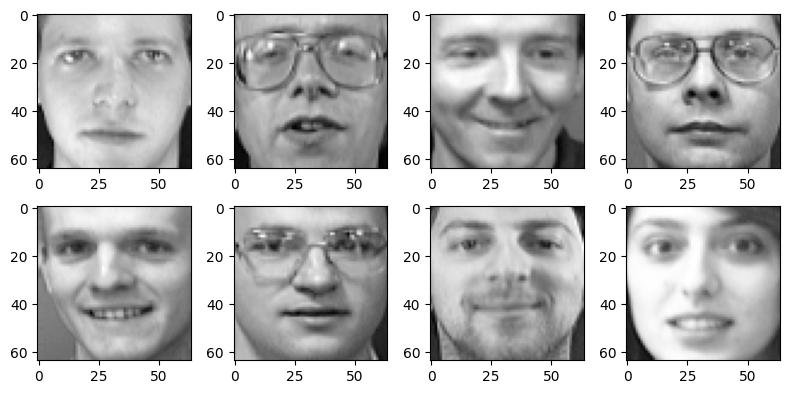

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))

axes[0][0].imshow(fetch_olivetti_faces()["images"][0], cmap='gray')
axes[0][1].imshow(fetch_olivetti_faces()["images"][10], cmap='gray')
axes[0][2].imshow(fetch_olivetti_faces()["images"][20], cmap='gray')
axes[0][3].imshow(fetch_olivetti_faces()["images"][30], cmap='gray')
axes[1][0].imshow(fetch_olivetti_faces()["images"][40], cmap='gray')
axes[1][1].imshow(fetch_olivetti_faces()["images"][50], cmap='gray')
axes[1][2].imshow(fetch_olivetti_faces()["images"][60], cmap='gray')
axes[1][3].imshow(fetch_olivetti_faces()["images"][70], cmap='gray')

plt.tight_layout()

### Partición en datos de entrenamiento y test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2048, stratify=y)

### Preprocesado de los datos

Los datos ya están normalizados entre 0 y 1:

In [5]:
np.min(X), np.max(X)

(0.0, 1.0)

In [6]:
def preprocesado(X, y, encoder=None):
    y = y.reshape(-1, 1)
    if encoder == None:
        encoder = OneHotEncoder(sparse_output=False)
        encoder.fit(y)
    y_one_hot = encoder.transform(y)

    return X, y_one_hot, encoder

In [7]:
X_train, y_train_onehot, one_hot_encoder = preprocesado(X_train, y_train)

### Reducción de dimensionalidad mediante PCA y visualización

Aplicamos PCA para reducir la dimensionalidad de las imágenes.

In [8]:
pca = PCA()
pca.fit(X_train);

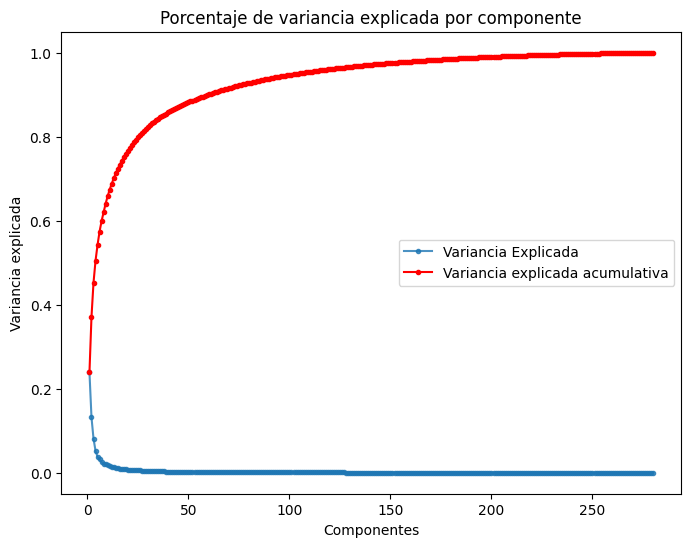

In [9]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Vemos que tan solo con unos 50 componentes tenemos más del 80% de la variancia de los datos.

In [10]:
X_train_pca = pca.transform(X_train)

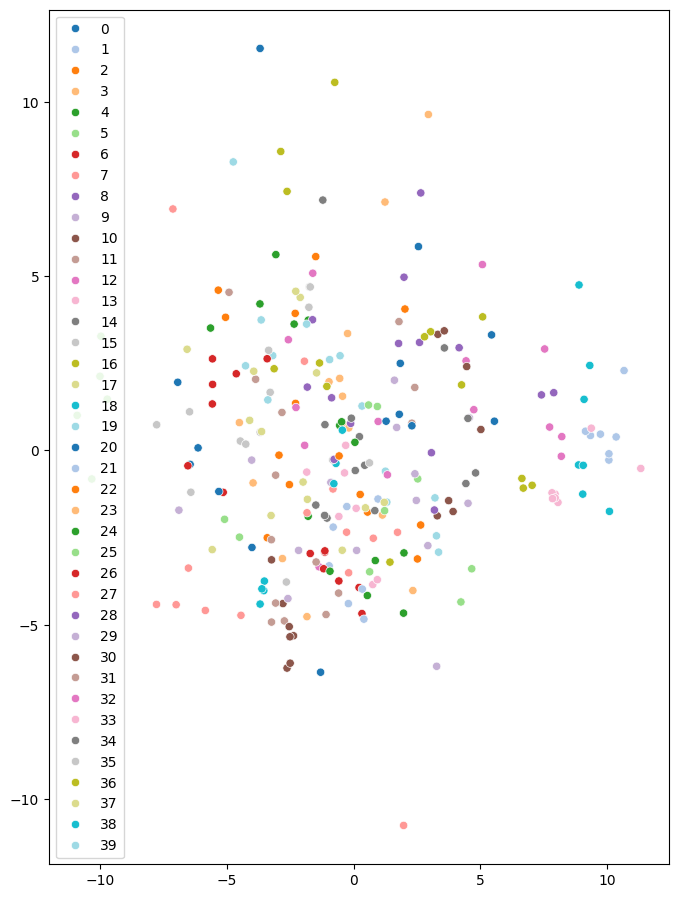

In [11]:
plt.figure(figsize=(8,11.1));
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, palette="tab20");

Se observa claramente que con dos dimensiones no podemos encontrar ninguna relación entre ejemplos de la misma clase. Es un problema muy complejo como para poder observar patrones con solamente dos dimensiones. Esto es consistente con la gráfica de variancia acumulada vista anteriormente: con dos componentes tenemos un 40% de la variancia explicada, mientras que si utilizamos 50 componentes llegamos al 80%.

Vamos a utilizar los 10 y 20 primeros componentes del PCA para los siguientes apartados, con los que conseguimos aproximadamente un 55% y 70% de la variancia, respectivamente.

In [12]:
X_train_pca_10 = X_train_pca[:, :10]
X_train_pca_20 = X_train_pca[:, :20]

Vamos a preprocesar los datos de test y vamos a aplicarles el PCA.

In [13]:
X_test, y_test_onehot, _ = preprocesado(X_test, y_test, one_hot_encoder)
X_test_pca = pca.transform(X_test)

X_test_pca_10 = X_test_pca[:, :10]
X_test_pca_20 = X_test_pca[:, :20]

### Ajuste del perceptrón multicapa

In [14]:
def save_results(model_name, model, X, y, df):
    y_pred = np.argmax(model.predict(X), axis=1)
    df.loc[model_name,'acc'] = accuracy_score(y, y_pred)
    df.loc[model_name,'precision score (W)'] = precision_score(y, y_pred, average='weighted')
    df.loc[model_name,'recall score (W)'] = recall_score(y, y_pred, average='weighted')
    df.loc[model_name,'f1 score (W)'] = f1_score(y, y_pred, average='weighted')
    return df

results_train_10 = pd.DataFrame()
results_test_10 = pd.DataFrame()
results_train_20 = pd.DataFrame()
results_test_20 = pd.DataFrame()
results_train_CNN = pd.DataFrame()
results_test_CNN = pd.DataFrame()

models = pd.DataFrame()

#### Con 10 componentes

In [15]:
neuron_numbers = [25, 50, 75, 100]

In [16]:
for neurons in neuron_numbers:
    model = keras.Sequential()
    model.add(keras.Input(shape=(10,)))
    model.add(keras.layers.Dense(neurons, activation="relu"))
    model.add(keras.layers.Dense(40, activation="softmax"))

    model.compile(optimizer=keras.optimizers.SGD(),loss=tf.keras.losses.CategoricalCrossentropy())
    model.fit(X_train_pca_10,y_train_onehot,batch_size=16,epochs=200,verbose=False)

    results_train_10 = save_results(f"10 componentes / {neurons} neuronas / train", model, X_train_pca_10, y_train, results_train_10)
    results_test_10 = save_results(f"10 componentes / {neurons} neuronas / test", model, X_test_pca_10, y_test, results_test_10)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step


In [17]:
results_train_10.sort_values(by="f1 score (W)", ascending=False)

,acc,precision score (W),recall score (W),f1 score (W)
10 componentes / 75 neuronas / train,0.996429,0.996875,0.996429,0.996410
10 componentes / 100 neuronas / train,0.996429,0.996875,0.996429,0.996410
10 componentes / 50 neuronas / train,0.978571,0.981944,0.978571,0.978349
10 componentes / 25 neuronas / train,0.946429,0.948214,0.946429,0.945650


Los resultados que se ven arriba son los que utilizan los datos de entrenamiento. Vemos que el modelo es muy bueno prediciendo estos datos. Los dos mejores modelos son los de 50 y 100 neuronas, que obtienen un f1-score de más del 99%. Naturalmente, como los datos que se han utilizado para entrenar el modelo son los mismos que estamos prediciendo aquí, estos resultados no son muy representativos del rendimiento del modelo en el mundo real. A continuación vamos a ver los resultados utilizando los datos de test.

In [18]:
results_test_10.sort_values(by="f1 score (W)", ascending=False)

,acc,precision score (W),recall score (W),f1 score (W)
10 componentes / 100 neuronas / test,0.900000,0.916667,0.900000,0.895595
10 componentes / 75 neuronas / test,0.891667,0.913333,0.891667,0.884405
10 componentes / 50 neuronas / test,0.866667,0.896667,0.866667,0.864048
10 componentes / 25 neuronas / test,0.866667,0.899167,0.866667,0.859940


Los datos de test nos muestran resultados más realistas. Con 50 neuronas, tenemos un f1-score entorno al 88%, un resultado bastante bueno. Los otros modelos (25, 75 y 100 neuronas) tienen resultados ligeramente peores. Parece que tener más neuronas, a partir de 25, no mejora los resultados. Tanto la precisión como la recuperación están balanceadas en todas las pruebas, por lo que el modelo es capaz de predecir correctamente las clases y no hay ninguna clase que se le escape, en la mayoría de casos.
#### Con 20 componentes
Vamos a probar ahora a utilizar los 20 primeros componentes del PCA para ver como se comporta el modelo.

In [19]:
neuron_numbers = [25, 50, 75, 100]

In [28]:
for neurons in neuron_numbers:
    model = keras.Sequential()
    model.add(keras.Input(shape=(20,)))
    model.add(keras.layers.Dense(neurons, activation="relu"))
    model.add(keras.layers.Dense(40, activation="softmax"))

    early = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    check = keras.callbacks.ModelCheckpoint('modelckpt.weights.h5',monitor='loss',save_best_only=True,save_weights_only=True)

    model.compile(optimizer=keras.optimizers.SGD(),loss=tf.keras.losses.CategoricalCrossentropy())
    model.fit(X_train_pca_20,y_train_onehot,batch_size=16,epochs=200,verbose=False,callbacks=[early, check])

    model.load_weights('modelckpt.weights.h5')

    results_train_20 = save_results(f"20 componentes / {neurons} neuronas / train", model, X_train_pca_20, y_train, results_train_20)
    results_test_20 = save_results(f"20 componentes / {neurons} neuronas / test", model, X_test_pca_20, y_test, results_test_20)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


In [29]:
results_train_20.sort_values(by="f1 score (W)", ascending=False)

,acc,precision score (W),recall score (W),f1 score (W)
20 componentes / 25 neuronas / train,1.0,1.0,1.0,1.0
20 componentes / 50 neuronas / train,1.0,1.0,1.0,1.0
20 componentes / 75 neuronas / train,1.0,1.0,1.0,1.0
20 componentes / 100 neuronas / train,1.0,1.0,1.0,1.0


In [30]:
results_test_20.sort_values(by="f1 score (W)", ascending=False)

,acc,precision score (W),recall score (W),f1 score (W)
20 componentes / 100 neuronas / test,0.950000,0.965000,0.950000,0.949464
20 componentes / 75 neuronas / test,0.933333,0.952917,0.933333,0.933452
20 componentes / 50 neuronas / test,0.933333,0.950417,0.933333,0.930060
20 componentes / 25 neuronas / test,0.908333,0.920833,0.908333,0.906905


La validación con el conjunto de test nos muestra que los resultados han mejorado considerablemente respecto a los modelos que utilizaban los 10 primeros componentes del PCA. Ahora, con 20 componentes, el modelo puede aprender mejor la complejidad de los datos. Recordamos que con 10 componentes, la variancia explicada acumulada estaba entorno al 55%, mientras que con 20 componentes obteníamos un 70%. Esta mejora se refleja en todos los modelos. Cabe destacar que ahora, los resultados con 25 y 50 neuronas son considerablemente peores  que con 75 y 100 neuronas. Los datos son mas complejos debido a que estamos utilizando 20 componentes, y parece que el número de neuronas tiene más importancia a la hora de poder aprender bien los datos.

### Ajuste de una red neuronal con capas convolucionales

Empezamos transformando los datos a matrices 3-dimensionales (la cuarta dimensión es la de los ejemplos).

In [31]:
X_train_3d = X_train.reshape(-1,64,64,1)
X_test_3d = X_test.reshape(-1,64,64,1)

In [32]:
neuron_numbers = range(1,11)

In [33]:
for neurons in neuron_numbers:
    model = keras.Sequential()
    model.add(keras.Input(shape=(64,64,1,)))
    model.add(keras.layers.Conv2D(filters=neurons, kernel_size=3,strides=1, activation="relu"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(40, activation="softmax"))

    early = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    check = keras.callbacks.ModelCheckpoint('modelckpt',monitor='loss',save_best_only=True,save_weights_only=True)

    model.compile(optimizer=keras.optimizers.SGD(),loss=tf.keras.losses.CategoricalCrossentropy())
    model.fit(X_train_3d,y_train_onehot,batch_size=16,epochs=200,verbose=False,callbacks=[early, check])

    model.load_weights('./modelckpt').expect_partial()

    results_train_CNN = save_results(f"CNN / {neurons} neuronas / train", model, X_train_3d, y_train, results_train_CNN)
    results_test_CNN = save_results(f"CNN / {neurons} neuronas / test", model, X_test_3d, y_test, results_test_CNN)

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=modelckpt

In [34]:
results_train_CNN.sort_values(by="f1 score (W)", ascending=False)

KeyError: 'f1 score (W)'

In [ ]:
results_test_CNN.sort_values(by="f1 score (W)", ascending=False)

Hemos mejorado significativamente los resultados respecto a los que habíamos obtenido con el perceptrón multicapa usando los 20 primeros componentes del PCA. Ahora llegamos a un f1-score de entorno al 98-99% en los datos de test, un resultado muy bueno. A este resultado se llega con multiples números de neuronas. Nuevamente, parece que no importa mucho en este caso cuántas neuronas tenemos siempre que tengamos dos o más. Con una sola neurona, si que se observa un f1-score significantemente más bajo que en los otros modelos. La mejora observada se debe a que las redes neuronales basadas en capas convolucionales son más adecuadas para trabajar con datos como imágenes, ya que intentan reproducir la visión humana. El hecho de que trabajemos con kernels (agrupaciones de multiples píxeles) hace que el modelo pueda ver la "big-picture" en vez de centrarse exactamente en cada píxel (o combinaciones de estos según como lo haya decidido el PCA), como lo hacía el MLP.

### Número de parámetros de las redes neuronales vs. convolucionales (respuesta al apartado d)

**Pregunta**: El método count_params() de la clase Model calcula cuántos parámetros tiene la red y el método summary calcula los parámetros por capa. Dado cómo se definen las capas convolucionales y las densas, explica cómo se calculan los tamaños y la cantidad de parámetros de las capas en las redes. Compara y comenta los resultados que se obtienen en los dos tipos de redes que has definido y las ventajas/inconvenientes que tienen respecto a su número de parámetros. ¿Cuáles habrían sido los tamaños de las capas de la red MLP si hubiéramos usado los datos en su forma original?

**Respuesta**: Antes de explicar como se calcula el número de parámetros, hay que tener en cuenta que en cada neurona tenemos un bias (sesgo) y en cada conexión entre neuronas tenemos un weight (peso). Tanto los bias como los weights son parámetros.

Las capas densas son capas de neuronas que estan completamente interconectadas entre si. Por ejemplo, en la siguiente red neuronal, donde tenemos una capa de input con 20 neuronas, una capa densa con 25 y la última con 40, todas posicionadas de forma secuencial (una detrás de la otra), tenemos:

- Pesos entre la capa de input y la primera capa densa: 20x25 = 500
- Biases de la primera capa densa = 25 (uno por neurona)
- Pesos entre la primera capa densa y la segunda capa densa: 25x40 = 1000
- Biases de la segunda capa densa: 40

En total, tenemos 500 + 25 + 1000 + 40 = 1565 parámetros, como refleja el count_params() a continuación:

In [35]:
model = keras.Sequential()
model.add(keras.Input(shape=(20,)))
model.add(keras.layers.Dense(25, activation="relu"))
model.add(keras.layers.Dense(40, activation="softmax"))

model.summary()
print(f"Total de parámetros: {model.count_params()}")

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 25)                │        525 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_34 (Dense)                │ (None, 40)                │      1,040 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,565 (6.11 KB)

 Trainable params: 1,565 (6.11 KB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 1565


Observamos ahora el número de parámetros que tenemos en la siguiente red convolucional, que tiene, de forma secuencial, las siguientes capas: una capa de entrada de 64x64 neuronas, una capa convolucional con 5 neuronas y tamaño de kernel igual a 3, una capa Flatten y finalmente una capa densa con 40 neuronas. El número de parámetros en esta capa es el siguiente:

- En la capa convolucional, tenemos un kernel de tamaño 3x3, y 5 filtros (neuronas). El número de inputs es 1, ya que las imágenes solamente tienen un canal (las imágenes son grayscale, no RGB u otros). Tenemos entonces 3x3x1x5 = 45 parámetros de los pesos. En la misma capa tenemos 5 parámetros de bias (uno para cada neurona), para un total de 50 parámetros. El output de esta capa es 62x62x5. No es 64 porque el filtro no se puede aplicar a los píxeles que están en los bordes. El 5 viene del número de filtros que se aplican.
- La capa Flatten no tiene ningún parámetro, simplemente transforma el output de la capa convolucional que está en 2 dimensiones a 1 dimensión. El output es entonces 62x62x5 = 19220
- La capa densa, como hemos visto antes, tiene todas las conexiones con la capa anterior y los biases para cada neurona: 19220x40+40 = 768840 parámetros.

En total, tenemos 50+768840 = 768890 parámetros.

In [36]:
model = keras.Sequential()
model.add(keras.Input(shape=(64,64,1,)))
model.add(keras.layers.Conv2D(filters=5, kernel_size=3,strides=1, activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(40, activation="softmax"))

model.summary()
print(f"Total de parámetros: {model.count_params()}")

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 5)         │         50 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 19220)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_35 (Dense)                │ (None, 40)                │    768,840 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 768,890 (2.93 MB)

 Trainable params: 768,890 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 768890


Las dos modelos de arriba son dos de los que se han utilizado para la tarea de reconocimiento facial. El primero es el que se ha usado con un perceptrón multicapa usando los datos del PCA, el segundo es la red convolucional en la que hemos utilizado los datos originales directamente. Recordamos que la CNN daba resultados bastante mejores que la MLP (f1-score de 95% contra el 99% de la CNN). No obstante, La diferencia en número de parámetros es muy grande, de más de 2 ordenes de magnitud (1000 contra 700000 parámetros) lo que significa que entrenar y hacer predicciones con la CNN es mucho más costoso que con el MLP. Aquí hay que hacer una valoración: ¿interesa más que sea muy fiable o que sea más rápido de calcular? La respuesta a esta pregunta variará dependiendo del caso de uso que se le quiera dar a la red.

Respecto a la última pregunta, si hubieramos usado los datos en su forma original (64x64x1), los tamaños de las capas MLP habrían sido los siguientes, asumiendo que estamos trabajando con la capa densa intermedia de 25 neuronas:

In [37]:
model = keras.Sequential()
model.add(keras.Input(shape=(64*64,)))
model.add(keras.layers.Dense(25, activation="relu"))
model.add(keras.layers.Dense(40, activation="softmax"))

model.summary()
print(f"Total de parámetros: {model.count_params()}")

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 25)                │    102,425 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_37 (Dense)                │ (None, 40)                │      1,040 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 103,465 (404.16 KB)

 Trainable params: 103,465 (404.16 KB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 103465


Observamos que de esta manera, el número de parámetros ya es del mismo orden que el de la CNN, y muy posiblemente no se comporte mejor, por lo que no valdría la pena utilizar este modelo en vez de la red neuronal con capas convolucionales.